In [1]:
# Install required packages
%pip install unsloth
%pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/unslothai/unsloth.git to c:\users\zhen\appdata\local\temp\pip-req-build-86a52x6q
  Resolved https://github.com/unslothai/unsloth.git to commit e596938ccf3750e153e7105f8123f94e0823d1e7
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for unsloth: filename=unsloth-2025.5.2-py3-none-any.whl size=265951 sha256=3be53ab4cd658f1fcdd0ba22580a452d125296c2ab11e00ae4e1ee6c03ad0eca
  Stored in directory: C:\Users\Zhen\AppData\Local\Temp\pip-ephem-wheel-cache-raqbvqyu\wheels\60\3e\1f\e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth
  Attempting uninstall: unsloth
    Found existing installation: unsloth 2025.5.2
    Uninstalling unsloth-2025.5.2:
   

  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git 'C:\Users\Zhen\AppData\Local\Temp\pip-req-build-86a52x6q'

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import all necessary libraries
import torch
import gc
from unsloth import FastLanguageModel
from datasets import load_from_disk
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth.chat_templates import get_chat_template, train_on_responses_only
import warnings
warnings.filterwarnings("ignore")

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Check GPU
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


c:\Users\Zhen\Documents\Soma_AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
GPU: NVIDIA GeForce RTX 4060
GPU Memory: 8.00 GB


In [3]:
# Load the prepared dataset
dataset_name = "educational_content_dataset"
dataset = load_from_disk(dataset_name)
print(f"Loaded dataset with {len(dataset)} examples")

Loaded dataset with 100 examples


In [4]:
# Stable model configuration
# Using Llama-3.2-1B which is proven stable
model_name = "unsloth/Llama-3.2-1B-Instruct"  
max_seq_length = 1024
dtype = torch.float16
load_in_4bit = True

In [5]:
# Load the model
print(f"Loading {model_name}...")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="cuda:0",
)

print("Model loaded successfully!")
print(f"GPU memory used: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

Loading unsloth/Llama-3.2-1B-Instruct...
==((====))==  Unsloth 2025.5.2: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4060. Num GPUs = 1. Max memory: 7.996 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model loaded successfully!
GPU memory used: 1.04 GB


In [6]:
# Apply LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # Can use higher rank with smaller model
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

print("LoRA adapters applied successfully!")

Unsloth 2025.5.2 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


LoRA adapters applied successfully!


In [7]:
# Apply chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3",  # Llama-3 format for Llama models
    map_eos_token=True,
)

# Set pad token
tokenizer.pad_token = tokenizer.eos_token

# Format the dataset
def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = []
    for convo in convos:
        text = tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    return {"text": texts}

print("Applying chat template to dataset...")
dataset = dataset.map(
    formatting_prompts_func, 
    batched=True,
    num_proc=1,  # Single process for Windows
    desc="Formatting prompts"
)

print("Chat template applied successfully")

Applying chat template to dataset...


Formatting prompts: 100%|██████████| 11/11 [00:00<00:00, 726.05 examples/s]

Chat template applied successfully


In [8]:
# Verify the dataset
print(f"Dataset size: {len(dataset)}")
print(f"Dataset columns: {dataset.column_names}")
print(f"First example length: {len(dataset[0]['text'])}")
print(f"Sample text: {dataset[0]['text'][:200]}...")

Dataset size: 11
Dataset columns: ['conversations', 'text']
First example length: 1110
Sample text: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an educational assistant that generates comprehensive study notes from educational content.<|eot_id|><|start_header_id|>user<|end_h...


In [9]:
# Stable training configuration
training_args = TrainingArguments(
    per_device_train_batch_size=2,  # Can use 2 with 1B model
    gradient_accumulation_steps=4,   # Effective batch size of 8
    warmup_steps=10,
    max_steps=200,  # More steps for better results
    learning_rate=2e-4,
    fp16=True,      # Use fp16
    bf16=False,     # Don't use bf16
    logging_steps=10,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="educational_model_outputs",
    save_strategy="steps",
    save_steps=100,
    gradient_checkpointing=True,
    max_grad_norm=0.5,
    report_to="none",
)

print("Training configuration set")

Training configuration set


In [10]:
# Create trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
    dataset_num_proc=1,  # MUST be 1 for Windows
    packing=False,  # Don't pack sequences
    args=training_args,
)

# Train only on assistant responses
trainer = train_on_responses_only(
    trainer,
    instruction_part="<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n",
    response_part="<|start_header_id|>assistant<|end_header_id|>\n\n",
)

print("Trainer initialized successfully")

Unsloth: Tokenizing ["text"]: 100%|██████████| 11/11 [00:00<00:00, 884.28 examples/s]
num_proc must be <= 11. Reducing num_proc to 11 for dataset of size 11.
Map (num_proc=11): 100%|██████████| 11/11 [00:07<00:00,  1.51 examples/s]


Trainer initialized successfully


In [11]:
# Train with error handling
print("Starting training...")
print(f"Training on {len(dataset)} examples")
print(f"Training for {training_args.max_steps} steps")

try:
    trainer_stats = trainer.train()
    
    print("\nTraining completed successfully!")
    print(f"Final training loss: {trainer_stats.training_loss:.4f}")
    
except Exception as e:
    print(f"Error during training: {e}")
    raise
    
finally:
    torch.cuda.empty_cache()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11 | Num Epochs = 200 | Total steps = 200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Starting training...
Training on 11 examples
Training for 200 steps
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.048300
20,0.475500
30,0.071900
40,0.007600
50,0.002300
60,0.001300
70,0.000800
80,0.000600
90,0.000500
100,0.000400



Training completed successfully!
Final training loss: 0.0806


In [12]:
# Enable inference mode
FastLanguageModel.for_inference(model)
print("Model set to inference mode")

Model set to inference mode


In [13]:
# Test the fine-tuned model
test_examples = [
    {
        "type": "notes",
        "text": "Machine learning is a subset of artificial intelligence that enables computers to learn from data."
    },
    {
        "type": "quiz",
        "text": "The water cycle describes how water evaporates, condenses, and precipitates."
    },
    {
        "type": "flashcards",
        "text": "Photosynthesis converts sunlight into chemical energy in plants."
    }
]

for example in test_examples:
    print(f"\n{'='*50}")
    print(f"Test: {example['type']}")
    print('='*50)
    
    # Create prompt
    if example['type'] == 'notes':
        system_msg = "You are an educational assistant that generates comprehensive study notes from educational content."
        user_msg = f"Create study notes from this text: '{example['text']}'"
    elif example['type'] == 'quiz':
        system_msg = "You are an educational assistant that creates quiz questions from educational content."
        user_msg = f"Generate quiz questions from this text: '{example['text']}'"
    else:
        system_msg = "You are an educational assistant that creates flashcards from educational content."
        user_msg = f"Create flashcards from this text: '{example['text']}'"
    
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": user_msg}
    ]
    
    # Generate
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")
    
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=256,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        repetition_penalty=1.1,
    )
    
    response = tokenizer.batch_decode(outputs)[0]
    print(response)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Test: notes
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an educational assistant that generates comprehensive study notes from educational content.<|eot_id|><|start_header_id|>user<|end_header_id|>

Create study notes from this text: 'Machine learning is a subset of artificial intelligence that enables computers to learn from data.'<|eot_id|><|start_header_id|>assistant<|end_header_id|>

🤖 **Machine Learning Study Notes**

**Definition**: Subset of Artificial Intelligence
**Key Characteristics**:
- Computers learn from data
- Does not require human intervention
- Uses algorithmic methods
- Applications wide range (health, finance, transportation)

**Key Technologies**:
- Machine Learning
- Deep Learning
- Natural Language Processing
- Computer Vision

**Applications**:
- Healthcare: Diagnosis, Drug Discovery
- Finance: Fraud Detection, Trading
- Transportation: Self-Driving Cars
- Entertainment: Content Recommendation

**Data Requirements**:
- Large datasets
-

In [14]:
# Save the fine-tuned model
model_name = "llama32_educational_finetuned"
print(f"Saving model to {model_name}/...")

model.save_pretrained(model_name)
tokenizer.save_pretrained(model_name)

print("Model saved successfully!")

Saving model to llama32_educational_finetuned/...
Model saved successfully!


In [17]:
# Create model information
import json
from datetime import datetime

model_info = {
    "base_model": "unsloth/Llama-3.2-1B-Instruct",
    "fine_tuned_date": datetime.now().strftime("%Y-%m-%d"),
    "training_examples": len(dataset),
    "training_steps": training_args.max_steps,
    "use_cases": [
        "Generate study notes from text",
        "Create quiz questions with answers",
        "Make flashcards for memorization"
    ],
    "model_size": "1B parameters",
    "quantization": "4-bit",
    "framework": "Unsloth + Transformers"
}

with open(f"{model_name}/model_info.json", "w") as f:
    json.dump(model_info, f, indent=2)

# Create README - Using simple string formatting
readme_lines = [
    "# Educational Content Generator - Llama 3.2 1B",
    "",
    "Fine-tuned Llama 3.2 1B model for generating educational content.",
    "",
    "## Model Details",
    f"- Base Model: {model_info['base_model']}",
    f"- Training Date: {model_info['fine_tuned_date']}",
    f"- Training Examples: {model_info['training_examples']}",
    f"- Model Size: {model_info['model_size']}",
    f"- Quantization: {model_info['quantization']}",
    "",
    "## Capabilities",
    "- Generate comprehensive study notes",
    "- Create quiz questions with answers",
    "- Produce flashcards for memorization",
    "",
    "## Usage",
    "```python",
    "from transformers import AutoModelForCausalLM, AutoTokenizer",
    "",
    f'model = AutoModelForCausalLM.from_pretrained("{model_name}")',
    f'tokenizer = AutoTokenizer.from_pretrained("{model_name}")',
    "```"
]

readme = "\n".join(readme_lines)

with open(f"{model_name}/README.md", "w") as f:
    f.write(readme)

print("Model documentation created!")

Model documentation created!


In [18]:
# Final cleanup
torch.cuda.empty_cache()
gc.collect()

print("\nTraining complete!")
print(f"Model saved to: {model_name}/")
print(f"Total GPU memory used: {torch.cuda.max_memory_allocated(0)/1024**3:.2f} GB")


Training complete!
Model saved to: llama32_educational_finetuned/
Total GPU memory used: 1.67 GB


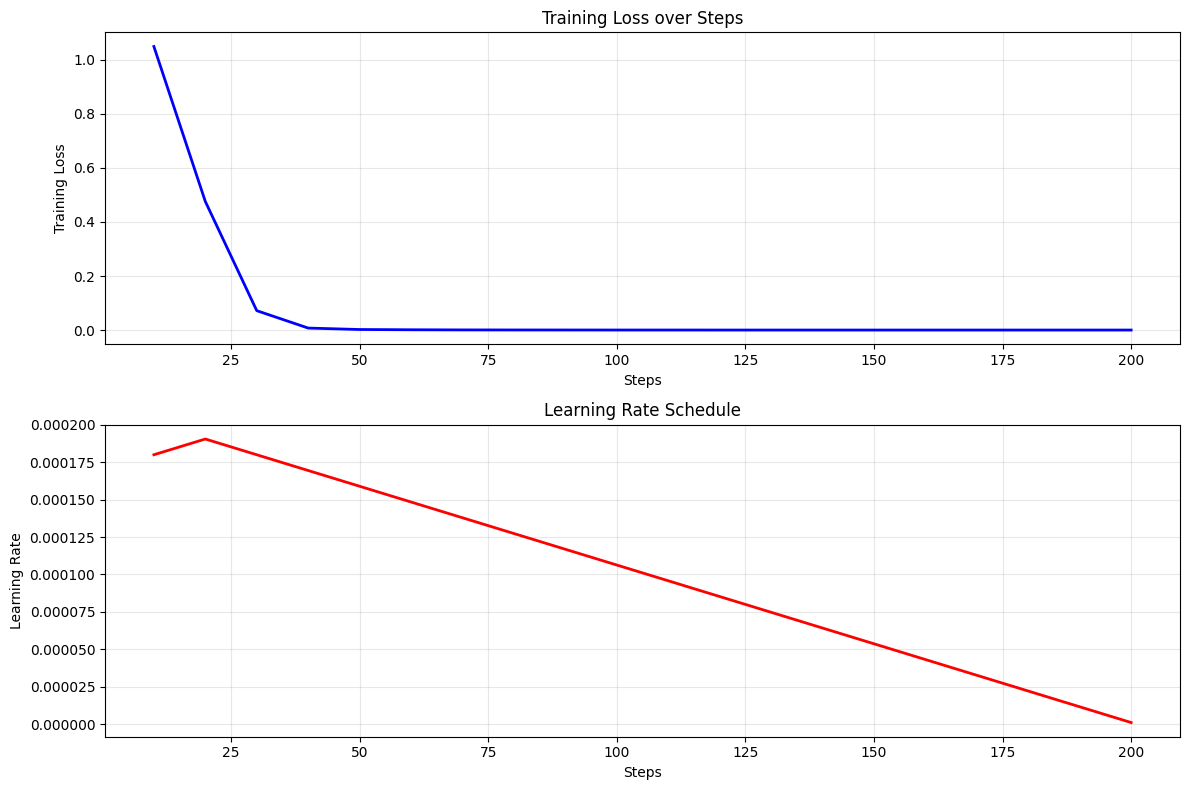

Initial Loss: 1.0483
Final Loss: 0.0003
Loss Reduction: 100.0%
Average Loss: 0.0806


In [20]:
# Extract and plot training metrics
import matplotlib.pyplot as plt
import numpy as np

# Get training history from trainer
training_history = trainer.state.log_history

# Extract metrics
steps = []
losses = []
learning_rates = []

for entry in training_history:
    if 'loss' in entry:
        steps.append(entry['step'])
        losses.append(entry['loss'])
        if 'learning_rate' in entry:
            learning_rates.append(entry['learning_rate'])

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot training loss
ax1.plot(steps, losses, 'b-', linewidth=2)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss over Steps')
ax1.grid(True, alpha=0.3)

# Plot learning rate
if learning_rates:
    ax2.plot(steps[:len(learning_rates)], learning_rates, 'r-', linewidth=2)
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Initial Loss: {losses[0]:.4f}")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Loss Reduction: {(losses[0] - losses[-1])/losses[0]*100:.1f}%")
print(f"Average Loss: {np.mean(losses):.4f}")

In [ ]:
# More comprehensive testing with scoring
test_cases = [
    {
        "type": "notes",
        "text": "Artificial intelligence is a field of computer science that aims to create intelligent machines that can perform tasks requiring human intelligence. It includes machine learning, natural language processing, and computer vision."
    },
    {
        "type": "quiz",
        "text": "The solar system consists of the Sun and eight planets. Mercury is the closest planet to the Sun, while Neptune is the farthest. Earth is the third planet from the Sun."
    },
    {
        "type": "flashcards",
        "text": "DNA stands for deoxyribonucleic acid. It is a molecule that contains genetic instructions for the development and function of living organisms."
    }
]

results = []

for i, test_case in enumerate(test_cases):
    print(f"\n{'='*60}")
    print(f"Test {i+1}: {test_case['type'].upper()}")
    print('='*60)
    
    # Create appropriate prompt
    if test_case['type'] == 'notes':
        system_msg = "You are an educational assistant that generates comprehensive study notes from educational content."
        user_msg = f"Create study notes from this text: '{test_case['text']}'"
    elif test_case['type'] == 'quiz':
        system_msg = "You are an educational assistant that creates quiz questions from educational content."
        user_msg = f"Generate quiz questions from this text: '{test_case['text']}'"
    else:
        system_msg = "You are an educational assistant that creates flashcards from educational content."
        user_msg = f"Create flashcards from this text: '{test_case['text']}'"
    
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": user_msg}
    ]
    
    # Tokenize
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")
    
    # Generate with different settings
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=300,
        temperature=0.8,
        do_sample=True,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.15,
        no_repeat_ngram_size=3,
    )
    
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    print(response)
    
    # Store result for analysis
    results.append({
        "type": test_case['type'],
        "input": test_case['text'],
        "output": response
    })